In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
keras = tf.keras
from datetime import datetime

In [2]:
from typing import List

In [3]:
import os
import glob

In [4]:
from src.io.load import DataLoader

In [5]:
from abc import ABC, abstractmethod

In [6]:
PATH_DATA_PROCESSED = "../data/processed/"

In [7]:
dict_data_name = {
    "germany": "BZN-DE-LU/"
}
class DataLoader:
    def __init__(self):
        pass

    def load_dataset(self, name, start_date=None, end_date=None):
        dir_name= os.path.join(PATH_DATA_PROCESSED, dict_data_name[name])
        return self._load_all_files(dir_name)

    def _load_all_files(self, dir_name):
        data_list = []
        for file in glob.glob(dir_name+"*.xlsx"):
            data_list.append(pd.read_excel(file))

        return pd.concat(data_list).reset_index(drop=True)

In [8]:
builder = DataLoader()

data = builder.load_dataset("germany", start_date=None, end_date=None)

In [9]:
class ProcessData:
    def __init__(self, df):
        self.df = df
        
    def run_preprocess(self):
        return self.format_data()
    
    def format_data(self):
        self.df['hour'] = self.df['Hours'].apply(lambda x: x[:2])
        self.df = self.df.drop('Hours', axis=1)
        self.df['time'] = pd.to_datetime(self.df['date']+self.df['hour'], format="%d/%m/%Y%H")
        self.df = self.df.set_index('time').sort_index()
        return self.df['value'].resample("H").last().sort_index()

In [10]:
processor = ProcessData(data)
prices = processor.run_preprocess()

In [11]:
prices = prices.to_frame()

In [12]:
top_p = prices.head(10)

## Factory

In [13]:
class ModelForecastFactory:

    def get_model(self, **kwargs):
        name = kwargs["name"]
        choice_model = {
            "arima":{
                "builder":ARIMAModel,
                "params":[
                    "order",
                    "seasona_order",
                ]
            }
        }
        params = {k:v for k,v in kwargs.items() if k in choice_model[name]["params"]}
        return choice_model[name]["builder"](**params)

* abstract factory

In [12]:
class SamplerSetForecast:
    def __init__(self, 
                 df: pd.DataFrame, 
                 prop: float = 0.2):
        self.df = df
        self.x_train, self.x_test = self.init_train_test_set(prop)
    
    def init_train_test_set(self, prop):
        """
        dates as df indices
        """
        self.split_idx = int((1-prop)*len(self.df))
        return self.split_train_test_set()
    
    def split_train_test_set(self):
        train_set, test_set = self.df[:self.split_idx], self.df[self.split_idx:]
        return train_set, test_set
    
    def resample_train_test_set(self, n_frames):
        self.split_idx +=n_frames
        return self.split_train_test_set()

In [13]:
sampler = SamplerSetForecast(prices)

In [14]:
sampler.x_test.shape

(5261,)

In [15]:
sampler.x_train.shape

(21043,)

In [18]:
class ForecastModel(ABC):
        
    @abstractmethod
    def forecast(self, n_frames):
        pass
    
    @abstractmethod
    def train_model(self, x_train):
        pass
    
    def format_prediction(self, x_test: pd.Series, predictions: List):
        return pd.Series(predictions, index=x_test.index)

In [20]:
from lightgbm import LGBMRegressor

In [21]:
class LGBMForecast(ForecastModel):
    def __init__(self, **params):
        self.params = params if params else []
        self.model = (
            LGBMRegressor(self.params) 
            if self.params else LGBMRegressor()
        )
    def init_

    def forecast(self, n_frames, x_test_window):
        x_input = x_test_window.iloc[0].values
        pred_day = []
    
        for _ in range(0, n_frames):
            if _ !=0:
                lags_features = [_ for _ in x_test.columns if _.startswith('t_')]
                other_columns = [_ for _ in x_test.columns if _ not in lags_features]

                tmp_lags = x_test[lags_features].iloc[n+_].values
                tmp_static = x_test[other_columns].iloc[n+_].values

                # we replace past day prices with forecasted ones
                tmp_lags[:_] = pred_day[::-1][:_]

                x_input = np.concatenate((tmp_lags, tmp_static), axis=0)
                
            last_pred = lgbm.predict(x_input.reshape(1, -1))

            pred_day.append(last_pred[0])
        
        return pd.Series(pred_day, index=x_test_window.index)
        
    def train_model(self, x_train, y_train):
        self.model.fit(x_train, y_train)

## Utils

In [14]:
from typing import Dict

In [15]:
class Scaler:
    def __init__(self):
        pass
    

In [16]:
class ProcessTimeSeries:
    def __init__(self):
        pass
    def differential_signal(self, df):
        pass

In [19]:
class ARIMAModel(ForecastModel):
    def __init__(self,
                 order:Dict[str, int],
                seasonal_order:float = None):
        
        self.order = order
        self.seasonal_order = seasonal_order
        
    def forecast(self, n_frames):
        return self.model.forecast(steps=n_frames)
    
    def train_model(self, x_train):
        self.model = ARIMA(
            endog=x_train, 
            order=(self.order["p"], self.order["d"], self.order["q"]), 
            freq='H', 
            seasonal_order=self.seasonal_order).fit()

In [34]:
class ForecastRunner:
    def __init__(self,
                model: ForecastModel,
                df,
                n_frames: int):
        self.model = model
        self.df = df
        self.sampler = None
        self.pred_prices = None
    
    def init_sampler(self):
        return SamplerSetForecast(self.df)
    
    def run_forecast(self, n_frames: int):
        return self.model.forecast(n_frames)
    
    def run_training(self, x_train):
        self.model.train_model(x_train)
        
    def run_sequential_window(self, n_frames, n_periods):
        pred_list: List[pd.Series] = []
        self.sampler = self.init_sampler()
        for idx in range(n_periods*n_frames):
            if idx % n_frames == 0:
                self.sampler.resample_train_test_set(n_frames)
                self.run_training(self.sampler.x_train)
                pred_list.append(self.run_forecast(n_frames))
                
        return pd.concat(pred_list, axis=0)

## Runner

In [22]:
builder = DataLoader()
data = builder.load_dataset("germany", start_date=None, end_date=None)

processor = ProcessData(data)
prices = processor.run_preprocess()

params = {
    "name":"arima",
    "order":dict(p=24, d=1, q=0),
    "seasonal_order":None,
}

model_builder = ModelForecastFactory()
model_forecast = model_builder.get_model(**params)


In [68]:
48%48

0

In [32]:
runner = ForecastRunner(model=model_forecast,
                  df=prices,
                 n_frames=24)

sampler = runner.init_sampler()

### Single run

In [245]:
%%time
runner.run_training(
    x_train=sampler.x_train
)


CPU times: user 4min 10s, sys: 6.52 s, total: 4min 17s
Wall time: 32.2 s


In [246]:
pred = runner.run_forecast(
    n_frames=48)

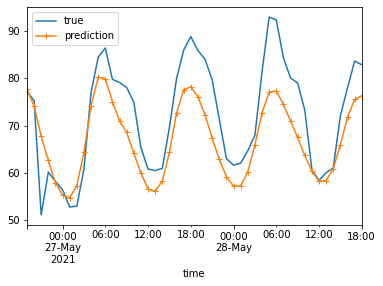

In [247]:
sampler.x_test[:48].plot(label='true')
pred.plot(label='prediction', marker='+')
plt.legend()

### Multi run

In [33]:
%%time
runner.run_sequential_window(n_frames=24, n_periods=4)

0
24
48
72
CPU times: user 16min 58s, sys: 28 s, total: 17min 26s
Wall time: 2min 10s


2021-05-26 19:00:00    77.703895
2021-05-26 20:00:00    74.141760
2021-05-26 21:00:00    67.673109
2021-05-26 22:00:00    62.589246
2021-05-26 23:00:00    57.846837
                         ...    
2021-05-27 14:00:00    58.207403
2021-05-27 15:00:00    64.326371
2021-05-27 16:00:00    72.673452
2021-05-27 17:00:00    77.531713
2021-05-27 18:00:00    78.244235
Name: predicted_mean, Length: 96, dtype: float64

In [ ]:
%%time
n_forecast = 24
n_curr_window = int(0.2*len(prices_s))
n_stop = 168
pred_list = []
for idx in range(n_stop):
    if idx % n_forecast == 0:
        self.sampler.resample()
        model_arima = arima_uni_var_fit(prices_s[:n_curr_window], p=24, d=1, q=0)
        pred_list.append(arima_uni_var_predict(model_arima, n_forecast))
    n_curr_window +=1

In [ ]:

class

In [73]:
from enum import Enum, auto

class TradeAction(Enum):
    BUY = 1
    SELL = -1
    HOLD = 0

In [71]:
trade_action = {
    1:TradeAction.BUY,
    0:TradeAction.HOLD,
    -1:TradeAction.SELL,
}

## Tests

In [7]:
from src.main import Experiment
from src.action_strategy.factory import ActionStrategy
from src.action_strategy.mean_reversion import MeanReversion
from src.forecast.factory import ModelForecastFactory
from src.forecast.runner import ForecastRunner
from src.forecast.utils import SamplerSetForecast
from src.io.load import DataLoader, load_config
from src.preprocessing.preprocess import ProcessData
from src.stock import Balance, Stock
import pandas as pd
import logging
from src.trade_manager import TradeManagerV0

In [8]:
from typing import Any

In [9]:
from src.main import dummy_func

In [16]:
log=logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

In [11]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [12]:

def load_data(name="germany"):
    builder = DataLoader()
    return builder.load_dataset(name, start_date=None, end_date=None)



In [124]:
test = forecast_runner.sampler.x_test.tail()

In [125]:
df = forecast_runner.sampler.x_test

In [136]:
df.loc[test.index].rename("rr")

time
2021-12-31 19:00:00     0.18
2021-12-31 20:00:00     0.08
2021-12-31 21:00:00     5.10
2021-12-31 22:00:00     6.32
2021-12-31 23:00:00    50.05
Freq: H, Name: rr, dtype: float64

In [153]:
for i, _ in test.items():
    print(_)

0.18
0.08
5.1
6.32
50.05


In [176]:
from dataclasses import dataclass, field

from src.action_strategy.factory import trade_action, TradeAction

@dataclass
class TradeManagerV0:
    strategy: ActionStrategy
    forecast_runner: ForecastRunner

    def trade_on_period(self):
        pass

    def run_trade(self, exp):
        self.forecast_runner.run_training()
        pred_prices = self.forecast_runner.run_forecast()
        pred_prices = pred_prices.to_frame("value")
        #return pred_prices
        results = self.strategy.get_action_window(pred_prices)

        for _,s_price in results.iterrows():
            self.trade_unit(s_price, exp)
        
        return results
        
    def trade_unit(self, s_price: pd.Series, exp):

        exp.stock.update_stock(s_price['action'])
        exp.balance.update_balance(s_price['action'], s_price['true_prices'])
        log.info(f"Current cpty : {exp.stock.current_cpty}")
        log.info(f"Current balance : {exp.balance.current_level}")


@dataclass
class Experiment:
    """ run experiment"""
    stock: Stock
    df: pd.DataFrame
    forecast_runner: ForecastRunner
    strategy: ActionStrategy
    balance: Balance
    

    def run(self):

        self.manager = TradeManagerV0(strategy=self.strategy,
                                forecast_runner=self.forecast_runner,
                                     )
        
        return self.manager.run_trade(self)
        

@dataclass
class MeanReversion(ActionStrategy):
    prices: pd.Series
    period: int
    alpha:float

    def get_indicator(self, prices):
        """bollinger bands"""
        prices = prices.to_frame()
        prices["mean"] = prices["value"].rolling(self.period, min_periods=1).mean()
        prices["std"] = prices["value"].rolling(self.period, min_periods=1).std()
        
        prices["upper_bollinger"] = prices["mean"] + (self.alpha * prices["std"])
        prices["lower_bollinger"] = prices["mean"] - (self.alpha * prices["std"])
        return prices

    def get_action_window(self, window_prices):

        self.prices = self.get_indicator(self.prices)
        window_prices['buy'] = (
            np.where(
                window_prices['value'] >= self.prices.loc[window_prices.index, 'upper_bollinger'], 
                1, 0,
                )
        )
        window_prices['sell'] = (
            np.where(
                window_prices['value'] <= self.prices.loc[window_prices.index, 'lower_bollinger'],
             -1, 0,
             )
        )
        window_prices['action'] = window_prices[['buy', 'sell']].sum(axis=1).map(trade_action)
        
        window_prices = window_prices.rename({"value":"pred_prices"}, axis=1) 
        true_prices = self.prices.loc[window_prices.index].rename({"value":"true_prices"}, axis=1)
        results = pd.concat([true_prices, window_prices], axis=1)

        return results
    
@dataclass
class Balance:
    init_level: float

    def __post_init__(self):
        self.init_balance()

    def init_balance(self):
        self.current_level = self.init_level

    def update_balance(self, action: str, price: float):
        transaction = {
            TradeAction.BUY.name: -1,
            TradeAction.SELL.name: 1,
            TradeAction.HOLD.name: 0,
        }
        #log.info(f"ACTION : {action}")
        self.current_level += transaction[action]*price
        return self


@dataclass
class Stock:
    storage_pwr: float
    rho_d: float
    rho_s: float
    t_discharge: float
    init_storage_cpty: float = 0
    current_cpty: float = field(init=False)
    storage_cpty: float = field(init=False)

    def __post_init__(self):
        self.init_stock()

    def init_stock(self):
        self.storage_cpty = int(self.storage_pwr*(self.t_discharge/self.rho_d))
        self.current_cpty = self.init_storage_cpty
    
    def update_stock(self, action: str):
        log.info(f"action Stock : {action}")
        if action == TradeAction.BUY.name:
            self.add_to_stock()
        elif action == TradeAction.SELL.name:
            self.retrieve_from_stock()
        log.info(f"Updated Stock : {self.current_cpty}")
        return self

    @property
    def is_empty(self):
        return self.current_cpty == 0
    
    @property
    def is_full(self):
        return self.current_cpty == self.storage_cpty

    def add_to_stock(self):
        qty = (
            min(
                (self.storage_cpty - self.current_cpty), 
                (self.storage_pwr*self.rho_s*1)
            )
        if not self.is_full else 0)
        log.info('---')
        log.info(f'current : {self.current_cpty} - action qty : {qty}')
        log.info('---')        
        self.current_cpty += qty
        

    def retrieve_from_stock(self):
        qty = (
            min(
                self.current_cpty, 
                (self.storage_pwr/self.rho_d*1)
            )
        if not self.is_empty else 0)
        log.info('---')
        log.info(f'current : {self.current_cpty} - action qty : -{qty}')
        log.info('---')
        self.current_cpty -= qty



In [187]:
2**(24)

16777216

In [188]:
2**10

1024

In [177]:
market_name = "germany"
config_file = "1"
window_predict = ("01-01-2017", "03-01-2017")
log.info("Load data and config..")

config_exp = load_config(config_file)
prices = load_data(market_name)
log.info("Process data ..")
prices = ProcessData(df=prices).run_preprocess()
log.info("Init classes..")

INFO:__main__:Load data and config..
INFO:__main__:Process data ..
INFO:__main__:Init classes..


In [198]:
@dataclass
class A:
    tr:str
        
@dataclass
class B:
    aa: A
    rd:int

In [199]:
a=A("re")
b=B(aa=a, rd=4)

In [200]:
a.tr = 'uuuu'

In [201]:
b.aa.tr

'uuuu'

In [179]:
stock = Stock(storage_pwr=config_exp["storage_pwr"], 
                rho_d=config_exp["rho_d"], 
                rho_s=config_exp["rho_s"],
                t_discharge=config_exp["t_discharge"],
                )
balance = Balance(init_level=config_exp["balance_init_level"])
sampler = SamplerSetForecast(df=prices, prop=0.2)

model_forecast = ModelForecastFactory().get_model(**{
                                    "name":"arima",
                                    "order":dict(p=24, d=1, q=0),
                                    "seasonal_order":None,
                                    })
log.info("Init forecast runner..")

forecast_runner = ForecastRunner(model=model_forecast,
                            n_frames=config_exp["n_frames"],
                            sampler=sampler,
                            )    

strategy = MeanReversion(prices=prices,
                    period=config_exp["period"],
                    alpha=config_exp["alpha"],
                    )

INFO:__main__:Init forecast runner..


In [180]:
config_exp

{'storage_cpty': 956,
 'storage_pwr': 100,
 'rho_d': 0.86,
 'rho_s': 0.86,
 'eta': 0.7,
 't_discharge': 8,
 'balance_init_level': 1000,
 'alpha': 0.7,
 'period': 23,
 'n_frames': 24}

In [181]:
exp = Experiment(stock=stock, 
                df=sampler.df,
                forecast_runner=forecast_runner,
                strategy=strategy,
                balance=balance,
                )

In [182]:
%%time
results = exp.run()

INFO:__main__:action Stock : BUY
INFO:__main__:---
INFO:__main__:current : 0 - action qty : 86.0
INFO:__main__:---
INFO:__main__:Updated Stock : 86.0
INFO:__main__:Current cpty : 86.0
INFO:__main__:Current balance : 922.74
INFO:__main__:action Stock : HOLD
INFO:__main__:Updated Stock : 86.0
INFO:__main__:Current cpty : 86.0
INFO:__main__:Current balance : 922.74
INFO:__main__:action Stock : HOLD
INFO:__main__:Updated Stock : 86.0
INFO:__main__:Current cpty : 86.0
INFO:__main__:Current balance : 922.74
INFO:__main__:action Stock : HOLD
INFO:__main__:Updated Stock : 86.0
INFO:__main__:Current cpty : 86.0
INFO:__main__:Current balance : 922.74
INFO:__main__:action Stock : SELL
INFO:__main__:---
INFO:__main__:current : 86.0 - action qty : -86.0
INFO:__main__:---
INFO:__main__:Updated Stock : 0.0
INFO:__main__:Current cpty : 0.0
INFO:__main__:Current balance : 980.89
INFO:__main__:action Stock : SELL
INFO:__main__:---
INFO:__main__:current : 0.0 - action qty : -0
INFO:__main__:---
INFO:__ma

CPU times: user 4min 43s, sys: 10.4 s, total: 4min 53s
Wall time: 37.3 s


In [183]:
results

,true_prices,mean,std,upper_bollinger,lower_bollinger,pred_prices,buy,sell,action
2021-05-26 19:00:00,77.26,65.807391,11.174083,73.629250,57.985533,77.703895,1,0,BUY
2021-05-26 20:00:00,75.28,66.237391,11.346258,74.179772,58.295011,74.141760,0,0,HOLD
2021-05-26 21:00:00,51.08,65.795217,11.740764,74.013752,57.576682,67.673109,0,0,HOLD
2021-05-26 22:00:00,60.13,66.028696,11.563396,74.123073,57.934318,62.589246,0,0,HOLD
2021-05-26 23:00:00,58.15,66.294783,11.293902,74.200514,58.389051,57.846837,0,-1,SELL
2021-05-27 00:00:00,56.37,66.521739,11.024974,74.239221,58.804258,55.209097,0,-1,SELL
2021-05-27 01:00:00,52.71,66.540435,11.000062,74.240478,58.840392,54.708143,0,-1,SELL
2021-05-27 02:00:00,52.90,66.243043,11.281141,74.139842,58.346245,57.219816,0,-1,SELL
2021-05-27 03:00:00,60.75,65.550435,11.098774,73.319577,57.781293,64.285478,0,0,HOLD
2021-05-27 04:00:00,77.00,65.220435,10.608968,72.646712,57.794157,74.204812,1,0,BUY


In [206]:
results = pd.read_excel('results/20220920_213512/results.xlsx', index_col=0)

In [207]:
results.head()

,true_prices,mean,std,upper_bollinger,lower_bollinger,pred_prices,buy,sell,action
2021-05-26 19:00:00,77.26,65.807391,11.174083,73.629250,57.985533,77.703895,0,-1,SELL
2021-05-26 20:00:00,75.28,66.237391,11.346258,74.179772,58.295011,74.141760,0,0,HOLD
2021-05-26 21:00:00,51.08,65.795217,11.740764,74.013752,57.576682,67.673109,0,0,HOLD
2021-05-26 22:00:00,60.13,66.028696,11.563396,74.123073,57.934318,62.589246,0,0,HOLD
2021-05-26 23:00:00,58.15,66.294783,11.293902,74.200514,58.389051,57.846837,1,0,BUY


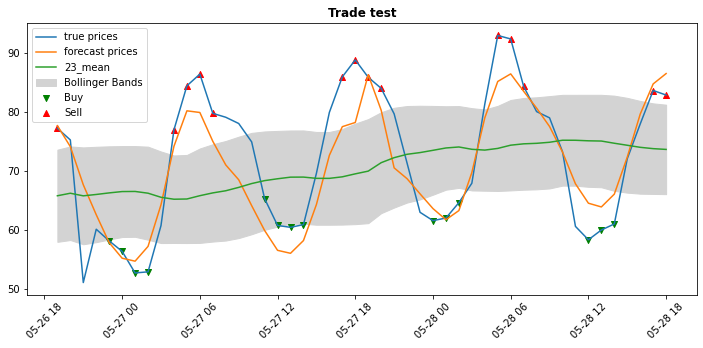

In [208]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(results.index, results.true_prices, label = 'true prices')
plt.plot(results.index, results.pred_prices, label = 'forecast prices')

plt.plot(results.index, results["mean"], label = '23_mean')
plt.fill_between(results.index, results['upper_bollinger'], results['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.scatter(results[(results['action'] == "BUY")].index, results[(results['action'] == "BUY")]['true_prices'], label = 'Buy', marker='v', c='g')
plt.scatter(results[(results['action'] == "SELL")].index, results[(results['action'] == "SELL")]['true_prices'], label = 'Sell', marker='^', c='r')

plt.title('Trade test', fontweight="bold")
plt.legend()
plt.show()

* alpha as signal saisonality coef

In [23]:
365*30

10950

In [24]:
10950/60

182.5